# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control

# Assignment 3 - Eigenfaces and SVD Applications

KARTHIK SUNDARARAJ<br>
KABILAN TAMILMANI<br>
SAHANESH PRAKASH

In [3]:
try:
    shell = get_ipython()
    shell.enable_pylab("inline")
except NameError:
    pass

import numpy as np
import matplotlib.pyplot as plt
            
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython
import imageio

from typing import Tuple, Sequence

**Hint**: Before you start solving the assignment, you might want to check the following functions:

```
imageio.imread
scipy.misc.imresize
numpy.linalg.eigh
```

## Eigenfaces [30 points]

Eigenvectors have many applications which are not limited to obtaining surface normals from a set of point clouds. In this assignment, you are asked to write your own facial recognition library. Take a look at the following image:

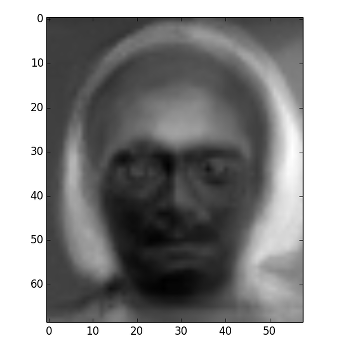

In [12]:
IPython.core.display.Image("images/eigenface.png")

This is what is called an *eigenface*. An eigenface really is nothing else than an eigenvector, in this case reshaped for plotting. Eigenfaces can be used in facial recognition, allowing a robot to distinguish between different persons, but can also be applied to other use cases, such as voice or gesture recognition.

**Your task consists of the following subtasks**:

1. Read the [Scholarpedia article](http://www.scholarpedia.org/article/Eigenfaces) about eigenfaces.
2. Implement the eigenface algorithm described in the article. In particular, create a Python class that exposes (at least) two methods:
    1. A method for calculating eigenfaces given two parameters, namely (i) a set of images and (ii) subject ids that uniquely identify the subjects in the images.
    2. A method that takes one parameter - a list of query faces - and, for each face in the input list, finds the subject id of the most similar face. This method should thus return a list of subject ids.

A dataset for training your recognition algorithm is given in the */srv/shared/data/faces/training* folder. The images in the */srv/shared/data/faces/test* folder should be used for testing the algorithm.

For your implementation, please use the method signatures given below. Use the code under **Testing your code** for loading the images and testing your implementation.

**Hint:** You might find Principal Component Analysis (PCA) useful.

In [5]:
class FaceRecognition(object):
    def __init__(self):
        self.subject_ids = list()
        self.faces = list()
        self.eigenface_weights = list()
        self.mean_image = list()

    def eigenfaces(self, image_filenames: Sequence[str],
                   subject_ids: Sequence[int]) -> None:
        '''Finds a set of eigenfaces based on the input images.
        The eigenfaces are saved in self.faces and self.eigenface_weights.

        Keyword arguments:
        image_filenames -- A list of image filenames
        subject_ids -- A list of IDs that uniquely identify the subjects
                       in the images

        '''
        ### BEGIN SOLUTION
        
        # source : http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf (reference)
        
        # Subject ids
        self.subject_ids = subject_ids
            
        # Number of Image - m (Count) 
        m = len(image_filenames)
            
        # Reading Train Image files 
        im = np.array([imageio.imread(image_filename) for image_filename in image_filenames])
            
        # Reshaping m-Train images (m,h,w) to vector form (D,m);  D =h*w 
        images = im.reshape((im.shape[0],(im.shape[1]*im.shape[2]))).T
            
        # Computing mean image (Psi) from Train Images; shape - (D,)
        self.mean_image = np.mean(images,axis=1) 
            
        # Subtracting mean image (Psi) from all the image to get A (Phi); shape - (D,m)
        A = np.array([image - self.mean_image for image in images.T]).T
            
        # Finding eigenvalues, eigenvectors (V) of (A.T*A) 
        eigenvalues, eigenvectors = np.linalg.eig(np.dot(A.T,A))
            
        # Computing EigenFace collection U such that ui = A.vi/||A.vi||
        self.faces = np.array([np.dot(A,v)/np.linalg.norm(np.dot(A,v)) for v in eigenvectors ])
            
        # Computing eigenface_weights (omega or basis) wi = ui.T*A 
        self.eigenface_weights = np.array([[np.dot(u.T,a) for u in self.faces] for a in A.T])
            
        # To write the EigenFace as images
        #for i in range(m):
        #    imageio.imwrite("mychecking/Eigenface_"+str(id)+"_"+str(i),U[i,:].reshape(231,195),format =".pgm")
        
        #raise NotImplementedError()
        ### END SOLUTION
        
    def recognize_faces(self, image_filenames: Sequence[str]) -> Sequence[int]:
        '''Finds the eigenfaces that have the highest similarity
        to the input images and returns a list with their indices.

        Keyword arguments:
        image_filenames -- A list of image filenames

        Returns:
        recognised_ids -- A list of ids that correspond to the classifier
                          predictions for the input images

        '''
        ### BEGIN SOLUTION
        
        # source : http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf (reference)
        
        # Initialising output list
        recognised_ids = list()
    
        for image_filename in image_filenames:
            
            # Reading Test Image file
            im = imageio.imread(image_filename)
            
            # Reshaping Test image (h,w) to vector form (D,);  D =h*w
            image = im.reshape((im.shape[0]*im.shape[1]))
                
            # Subtracting mean image (Psi) from test image to get A (Phi)
            A = image - self.mean_image
                
            # Computing eigenface_weights (omega or basis) wi = ui.T*A
            eigenface_weight = np.array([np.dot(u.T,A) for u in self.faces]).T
                
            # Computing  e_r - distance within the face space
            # e_r = min ||testomega - trainedomega[l]|| where l - all trained faces
            e_r_array = [np.linalg.norm(eigenface_weight-self.eigenface_weights[l]) for l in range(self.eigenface_weights.shape[1])]
            e_r = min(e_r_array)
            
            # Selecting subject id which has mininum e_r compared to others
            recognised_id = self.subject_ids[e_r_array.index(e_r)]
            
            # Appending recognised id to our final result
            recognised_ids.append(recognised_id)
            
        '''delete this     
        dummy  = [1,1,1,1,2,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,6,7,7,7,7,8,8,8,9,9,9,9,9,10,10,10,11,11,11,11,11,12,12,12,13,13,14,14,14,14,15,15,15,15,15]
        '''
        # Returning result
        return recognised_ids
        #raise NotImplementedError()
        ### END SOLUTION

### Testing your code

In [6]:
import os
import glob

#loading training images
training_image_filenames = sorted(glob.iglob('/srv/shared/data/faces/training/*.pgm'))

#loading test images
test_image_filenames = sorted(glob.iglob('/srv/shared/data/faces/test/*.pgm'))

#creating a lambda function for extracting filenames;
#the filename of each image is the subject id
subject_number = lambda filename: int(os.path.basename(filename)[7:9])

#extracting the filename using the lambda function
train_subject_ids = list (map(subject_number, training_image_filenames))
test_subject_ids = list (map(subject_number, test_image_filenames))

print('Test subject ids:', np.array(test_subject_ids))

face_recognition = FaceRecognition()
face_recognition.eigenfaces(training_image_filenames, train_subject_ids)
recognized_ids = face_recognition.recognize_faces(test_image_filenames)
print('Predicted subject ids:', recognized_ids)

different_results = np.array(test_subject_ids) - np.array(recognized_ids)
positives = (different_results == 0).sum()
accuracy = positives / (len(test_subject_ids) * 1.)
print('Number of correct predictions =', positives)
print('Prediction accuracy =', accuracy)

Test subject ids: [ 1  1  1  1  2  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  6  7  7  7
  7  8  8  8  9  9  9  9  9 10 10 10 11 11 11 11 11 12 12 12 13 13 14 14
 14 14 15 15 15 15 15]
Predicted subject ids: [6, 1, 2, 1, 2, 3, 3, 14, 4, 4, 14, 4, 5, 5, 9, 5, 6, 6, 2, 6, 6, 7, 7, 7, 7, 8, 2, 8, 9, 9, 8, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 1, 12, 12, 13, 13, 14, 14, 4, 14, 7, 3, 15, 15, 15]
Number of correct predictions = 43
Prediction accuracy = 0.7818181818181819


In [7]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!


## Line fitting [25 points]

Assume that our robot captures the following point cloud using its Kinect sensor:

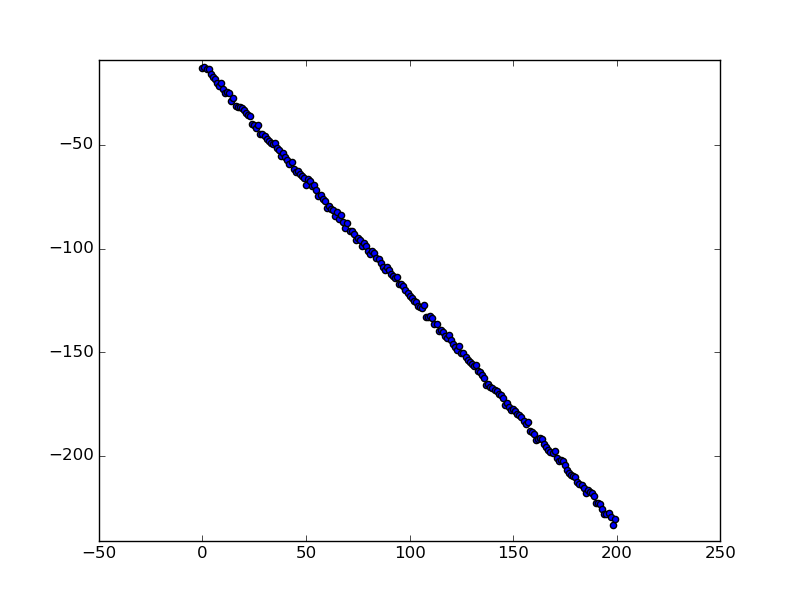

In [8]:
IPython.core.display.Image("images/line.png", embed=True)

Your task in this exercise is to use the SVD for fitting a line to the captured point cloud.

**Hint 1**: Take a look at the slides for the upcoming lecture and understand what the pseudo-inverse is and does.

**Hint 2**: The upcoming lecture slides contain a line fitting example, but we are not after that solution in this exercise; do **not** use that example as a guideline.

**Hint 3**: Represent the line as $y = mx + c$, where $m$ is the line's slope and $c$ is the $y$ intercept.

### Mathematical model [10 points]

Before we start implementing anything, we need to formalise our problem. Your first task is thus formulating the given line fitting problem mathematically. Please write your formulation in the cell below.

Our goal is to find slope $m$ and $y$ intercept $c$, such that the resulting line fits all the points in the point cloud
<blockquote>Representation of line :  $y = mx + c$</blockquote>
$$mx+c=y$$
$$
m  \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} 
+ c\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} 
=  \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} 
$$

$$
\begin{bmatrix} x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_n & 1 \end{bmatrix}
\begin{bmatrix} m \\ c \end{bmatrix} =
\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
$$
$$AP = B$$
<blockquote>where $P = [m,c]^T$ </blockquote>
To solve this equation in a simple way, 
<blockquote> Multiply both sides with $A^T$ </blockquote>
$$A^T.AP = A^T.B$$
$$\therefore P = (A^T.A)^{-1}.A^T.B$$
<blockquote>$(A^T.A)^{-1}$ can be found by calculating SVD of $(A^T.A)$ and taking Pseudo Inverse</blockquote>
By Solving $P = (A^T.A)^{-1}.A^T.B$, the values of $m$ and $c$ can be acquired
<br><br>
source : https://math.stackexchange.com/questions/260856/algorithm-to-get-inverse-parabola-fitting 

### Implementation [15 points]

After formalising the problem mathematically, your task is to implement your solution and obtain the parameters of the line that goes through the point cloud. The individual points of the point cloud are given in the file *data/line.npy*.

Once you fit the line, please plot the points and overlay the line on top of them; you will know that your solution is correct if your line is passing through the points.

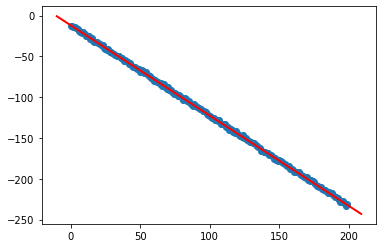

In [9]:
def line_fit(data: np.array) -> Tuple[float, float]:
    '''Returns the slope and intercept of the line
    that fits the given data points.

    Keyword arguments:
    data: np.array -- a 2D array in which each row
                      represents an (x, y) point

    '''
    ### BEGIN SOLUTION
    x = np.array(data[:,0]).T
    y = np.array(data[:,1]).T
    
    # A and B Matrices
    A = np.vstack((x,np.ones(x.shape))).T
    B = y

    # SVD of AT.A
    U, s, VT = numpy.linalg.svd(np.dot(A.T,A))
    V = VT.T
    S_inverse = np.diag(1/s)
    
    # Finding P
    P = np.dot(np.dot(np.dot(V,S_inverse),U.T), np.dot(A.T,B))
    
    m,c = P[0],P[1]
    
    return (m,c)
    #raise NotImplementedError()

    ### END SOLUTION

# we load the data and find the line parameters
data = np.load('data/line.npy')
m, c = line_fit(data)

# we plot the points and the overlayed line
x = np.linspace(np.min(data[:,0]) - 10, np.max(data[:,0]) + 10, 1000)
y = m * x + c
plt.scatter(data[:,0], data[:,1])
plt.plot(x, y, color='r', linewidth=2)
plt.show()

In [10]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!


### Parabola fitting [25 points]

Let's suppose that we are given a set of points that roughly lie on a parabola:

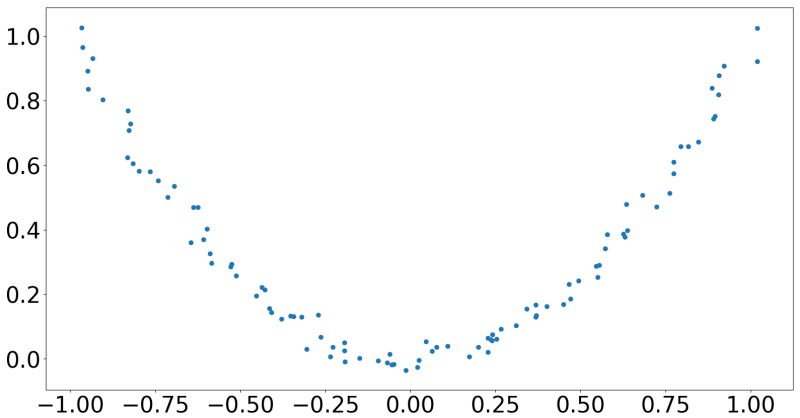

In [9]:
IPython.core.display.Image("images/parabola.png", embed=True)

Your task in this exercise is to use the SVD for fitting a parabola to the given points.

**Hint**: Recall that a parabola is a conic section. In particular, represent the parabola as $ax^2 + bx + cy = 0$ and use that to find its parameters.

### Mathematical model [10 points]

Just as in the line fitting problem, we need to formalise our problem before we start implementing anything; your first task is thus formulating the parabola fitting problem mathematically. Please write your formulation in the cell below.

Our goal is to find $a$, $b$ and $c$ in $ ax^2+bx+cy =0$, such that the resulting Parabola fits all the points in the point cloud
<blockquote> Representation of parabola : $ ax^2+bx+cy =0$ </blockquote>
$$ax^2+bx+cy =0$$
    
$$
a  \begin{bmatrix} x_1^2 \\ x_2^2 \\ \vdots \\ x_n^2 \end{bmatrix} 
+ b \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} 
+ c \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
= 0
$$
    
<blockquote>Divide by c,</blockquote>
$$
a/c  \begin{bmatrix} x_1^2 \\ x_2^2 \\ \vdots \\ x_n^2 \end{bmatrix} 
+ b/c \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} 
+ \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
= 0
$$
    
$$
a/c  \begin{bmatrix} x_1^2 \\ x_2^2 \\ \vdots \\ x_n^2 \end{bmatrix} 
+ b/c \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} 
= -1* \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
$$

$$
\begin{bmatrix} x_1^2 & x_1 \\ x_2^2 & x_2 \\ \vdots & \vdots \\ x_n^2 & x_n \end{bmatrix}
\begin{bmatrix} a/c \\ b/c  \end{bmatrix} =
 \begin{bmatrix} -y_1 \\ -y_2 \\ \vdots \\ -y_n \end{bmatrix}
$$
    
$$AP = B$$
<blockquote>where $P = [a/c,b/c]^T$ </blockquote>
Similar to previous problem <br>
To solve this equation in a simple way, 
<blockquote> Multiply both sides with $A^T$ </blockquote>
$$A^T.AP = A^T.B$$
$$\therefore P = (A^T.A)^{-1}.A^T.B$$
<blockquote>$(A^T.A)^{-1}$ can be found by calculating SVD of $(A^T.A)$ and taking Pseudo Inverse</blockquote>
By Solving $P = (A^T.A)^{-1}.A^T.B$, the values of $a/c$ and $b/c$ can be acquired <br>
$(a/c)$ and $(b/c)$ are the roots of the equation $ ax^2+bx+cy =0$ and for any non-zero real number $c$, the resulting parabola remains the same<br>
<blockquote>$\therefore$ By assuming $c=1$ (non-zero real number), $a$ and $b$ can be determined</blockquote>
<br><br>
source :https://math.stackexchange.com/questions/260856/algorithm-to-get-inverse-parabola-fitting

### Implementation [15 points]

After formalising the problem, your task is to implement your solution and obtain the parameters of the parabola that goes through the point cloud. The individual points of the point cloud are given in the file *data/parabola.txt*.

Once you fit the parabola, please plot the points and overlay the parabola on top of them; you will know that your solution is correct if your parabola is passing through the points.

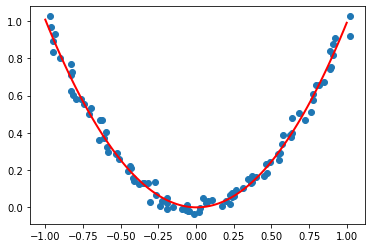

In [11]:
def parabola_fit(data: np.array) -> Tuple[float, float, float]:
    '''Returns the parabola parameters (assuming that
    the parabola is represented as ax^2 + bx + cy = 0).

    Keyword arguments:
    data: np.array -- a 2D array in which each row
                      represents an (x, y) point

    '''
    ### BEGIN SOLUTION
    x = np.array(data[:,0]).T
    y = np.array(data[:,1]).T
    
    # A and B Matrices
    A = np.vstack((x**2,x)).T
    B = -1*y
    
    # SVD of AT.A
    U, s, VT = numpy.linalg.svd(np.dot(A.T,A))
    V = VT.T
    S_inverse = np.diag(1/s)
    
    # Finding P
    P = np.dot(np.dot(np.dot(V,S_inverse),U.T), np.dot(A.T,B))
    
    c = 1
    a ,b = c*P[0],c*P[1]

    return (a,b,c)
    #raise NotImplementedError()

    ### END SOLUTION

# we load the data and find the parabola parameters
data = np.genfromtxt('data/parabola.txt')
a, b, c = parabola_fit(data)

# we plot the points and the overlayed parabola
x = np.linspace(-1, 1, 100)
y = (-a * x**2 - b * x) / c
plt.scatter(data[:,0], data[:,1])
plt.plot(x, y, color='r', linewidth=2)
plt.show()

In [ ]:
### THIS CELL CONTAINS AUTOMATED TESTS OF YOUR SOLUTION; DO NOT DELETE IT!
